In [89]:
# Data
import numpy as np

# if __name__ == '__main__':
with open('data/text_data/japan.txt', 'r') as f:
    txt = f.read()

    X = []
    y = []

    char_to_idx = {char: i for i, char in enumerate(set(txt))}
    idx_to_char = {i: char for i, char in enumerate(set(txt))}
    
    X = [char_to_idx[x] for x in txt]
    X = np.array(X)
    y = [char_to_idx[x] for x in txt[1:]]
    y.append(char_to_idx['.'])
    y = np.array(y)

In [94]:
# Model
import impl.layer as l

class RNN:

    def __init__(self, D, H, C, L, p_dropout):
        self.L = L
        self.H = H
        self.D = D
        self.losses = {'train':[], 'smooth train':[]}
        self.p_dropout = p_dropout
        
        # Input layer
        m_in = dict(
            Wx=np.random.randn(D, H) / np.sqrt(D / 2.),
            bx=np.zeros((1, H))
            )

        # Hidden layers
        m_h = dict(
            Wxh=np.random.randn(H, H) / np.sqrt(H / 2.),
            Whh=np.random.randn(H, H) / np.sqrt(H / 2.),
            Wx=np.random.randn(H, H) / np.sqrt(H / 2.),
            Wh=np.random.randn(H, H) / np.sqrt(H / 2.),
            bxh=np.zeros((1, H)),
            bx=np.zeros((1, H)),
            bh=np.zeros((1, H))
            )
            
        # Output layer
        m_out = dict(
            Wy=np.random.randn(H, C) / np.sqrt(H / 2.),
            by=np.zeros((1, C))
            )
        
        # Model parameters
        self.model = []
        self.model.append(m_in) # input layer: layer == 0
        for _ in range(self.L): # hidden layer: layer == 1:self.L
            self.model.append(m_h)
        self.model.append(m_out) # output layer: layer == self.L
                
    def initial_state(self):
        return np.zeros((1, self.H))

    def selu_forward(self, X):
        alpha = 1.6732632423543772848170429916717
        scale = 1.0507009873554804934193349852946
        out = scale * np.where(X>=0.0, X, alpha * (np.exp(X)-1))
        cache = X
        return out, cache

    def selu_backward(self, dout, cache):
        alpha = 1.6732632423543772848170429916717
        scale = 1.0507009873554804934193349852946
        X = cache
        dX_pos = dout.copy()
        dX_pos[X<0] = 0
        dX_neg = dout.copy()
        dX_neg[X>0] = 0
        dX = scale * np.where(X>=0.0, dX_pos, dX_neg * alpha * np.exp(X))
        return dX

    # p_dropout = keep_prob in this case! 
    # Is this true in other cases as well?
    def alpha_dropout_fwd(self, h, q):
        '''h is activation, q is keep probability: q=1-p, p=p_dropout, and q=keep_prob'''
        alpha = 1.6732632423543772848170429916717
        scale = 1.0507009873554804934193349852946
        alpha_p = -scale * alpha
        mask = np.random.binomial(1, q, size=h.shape)
        dropped = (mask * h) + ((1 - mask) * alpha_p)
        a = 1. / np.sqrt(q + (alpha_p ** 2 * q  * (1 - q)))
        b = -a * (1 - q) * alpha_p
        out = (a * dropped) + b
        cache = (a, mask)
        return out, cache

    def alpha_dropout_bwd(self, dout, cache):
        a, mask = cache
        d_dropped = dout * a
        dh = d_dropped * mask
        return dh
    
    def forward(self, X, h, m):
        Wxh, Whh, bxh = m['Wxh'], m['Whh'], m['bxh']
        Xh = (X @ Wxh) + (h @ Whh) + bxh
        Xh, Xh_nl_cache = l.tanh_forward(Xh)
        # Xh, Xh_nl_cache = self.selu_forward(Xh)
        
        Wx, bx = m['Wx'], m['bx']
        X_in = X.copy()
        # X = (X @ Wx) + bx
        X, X_fc_cache = l.fc_forward(X, Wx, bx)
        X, X_nl_cache = l.tanh_forward(X)
        # X, X_nl_cache = self.selu_forward(X)
        X += X_in
        
        Wh, bh = m['Wh'], m['bh']
        h_in = h.copy()
        # h = (h @ Wh) + bh
        h, h_fc_cache = l.fc_forward(h, Wh, bh)
        h, h_nl_cache = l.tanh_forward(h)
        # h, h_nl_cache = self.selu_forward(h)
        h += h_in
        
        h = Xh + h
        y = Xh + X

        h, h_selu_nl_cache = self.selu_forward(h)
        h, h_selu_do_cache = self.alpha_dropout_fwd(h, self.p_dropout)
        
        y, y_selu_nl_cache = self.selu_forward(y)
        y, y_selu_do_cache = self.alpha_dropout_fwd(y, self.p_dropout)
        
        cache = (X_in, h_in, Wxh, Whh, Xh_nl_cache, X_fc_cache, X_nl_cache, h_fc_cache, h_nl_cache, h_selu_nl_cache, h_selu_do_cache, y_selu_nl_cache, y_selu_do_cache)

        return y, h, cache

    def backward(self, dy, dh, cache):
        (X_in, h_in, Wxh, Whh, Xh_nl_cache, X_fc_cache, X_nl_cache, h_fc_cache, h_nl_cache, h_selu_nl_cache, h_selu_do_cache, y_selu_nl_cache, y_selu_do_cache) = cache
         
        dh = self.alpha_dropout_bwd(dh, h_selu_do_cache)
        dh = self.selu_backward(dh, h_selu_nl_cache)
        
        dy = self.alpha_dropout_bwd(dy, y_selu_do_cache)
        dy = self.selu_backward(dy, y_selu_nl_cache)

        dh_out = dh.copy()
        # dh = self.selu_backward(dh, h_nl_cache)
        dh = l.tanh_backward(dh, h_nl_cache)
        dh, dWh, dbh = l.fc_backward(dh, h_fc_cache)
        dh += dh_out
        #         dWh = h_in.T @ dh # nxh = nx1 @ 1xh
        #         dbh = dh * 1.0
        #         dh = dh @ Wh.T # 1xn = 1xh @ hxn

        dX = dy.copy()
        # dX = self.selu_backward(dX, X_nl_cache)
        dX = l.tanh_backward(dX, X_nl_cache)
        dX, dWx, dbx = l.fc_backward(dX, X_fc_cache)
        dX += dy
        #         dWx = X_in.T @ dX # nxh = nx1 @ 1xh
        #         dbx = dX * 1.0
        #         dX = dX @ Wx.T # 1xn = 1xh @ hxn

        dXh = dy + dh        
        # dXh = self.selu_backward(dXh, Xh_nl_cache)
        dXh = l.tanh_backward(dXh, Xh_nl_cache)
        dbxh = dXh * 1.0
        dWhh = h_in.T @ dXh
        dWxh = X_in.T @ dXh
        dX += dXh @ Wxh.T # 1xn = 1xh @ hxn
        dh += dXh @ Whh.T # 1xn = 1xh @ hxn

        grad = dict(Wxh=dWxh, Whh=dWhh, bxh=dbxh, Wx=dWx, bx=dbx, Wh=dWh, bh=dbh)
        
        return dX, dh, grad

    def train_forward(self, X_train, h):
        # Input (1), hidden (L), and output layers (1)
        caches = []
        h_init = h.copy()
        h = []
        # Hidden layers and cells connections
        for _ in range(self.L + 2):
            h.append(h_init.copy())
            caches.append([])
            
        # Hidden layers    
        for layer in range(self.L + 2):
            if layer == 0: # input layer
                ys = []
                for X in X_train:
                    X_one_hot = np.zeros(self.D)
                    X_one_hot[X] = 1.
                    X = X_one_hot.reshape(1, -1)
                    y, cache = l.fc_forward(X, self.model[layer]['Wx'], self.model[layer]['bx'])
                    # print(y.shape, X.shape)
                    caches[layer].append(cache)
                    ys.append(y)
            if (layer > 0) and (layer < self.L + 1): # hidden layers
                Xs = ys.copy()
                ys = []
                for X in Xs:
                    y, h[layer], cache = self.forward(X, h[layer], self.model[layer])
                    caches[layer].append(cache)
                    ys.append(y)
            if layer == self.L + 1: # output layer
                Xs = ys.copy()
                ys = []
                for X in Xs:
                    y, cache = l.fc_forward(X, self.model[layer]['Wy'], self.model[layer]['by'])
                    caches[layer].append(cache)
                    ys.append(y)

        return ys, caches

    def cross_entropy(self, y_pred, y_train):
        m = y_pred.shape[0]

        prob = l.softmax(y_pred)
        log_like = -np.log(prob[range(m), y_train])
        data_loss = np.sum(log_like) / m

        return data_loss

    def dcross_entropy(self, y_pred, y_train):
        m = y_pred.shape[0]

        grad_y = l.softmax(y_pred)
        grad_y[range(m), y_train] -= 1.0
        grad_y /= m

        return grad_y
    
    def loss_function(self, y_train, ys):
        loss, dys = 0.0, []

        for y_pred, y in zip(ys, y_train):
            loss += self.cross_entropy(y_pred, y)
            dy = self.dcross_entropy(y_pred, y)
            dys.append(dy)
            
        return loss, dys
    
    def train_backward(self, dys, caches):
        dh, grad, grads = [], [], []
        for layer in range(self.L + 2):
            dh.append(np.zeros((1, self.H)))
            grad.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})
            grads.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})
         
        for layer in reversed(range(self.L + 2)):
            if layer == (self.L + 1):  # Output layer
                dXs = []
                for t in reversed(range(len(dys))):
                    dy = dys[t]
                    dX, dWy, dby = l.fc_backward(dy, caches[layer][t])
                    grads[layer]['Wy'] += dWy
                    grads[layer]['by'] += dby
                    dXs.append(dX)
            if (layer > 0) and (layer < (self.L + 1)): # Middle layers
                dys = dXs.copy()
                dXs = []
                for t in reversed(range(len(dys))):
                    dy = dys[t]
                    dX, dh[layer], grad[layer] = self.backward(dy, dh[layer], caches[layer][t])
                    for key in grad[layer].keys():
                        grads[layer][key] += grad[layer][key]
                    dXs.append(dX)
            if layer == 0: # Input-Output layer
                dys = dXs.copy()
                dXs = []
                for t in reversed(range(len(dys))):
                    dy = dys[t]
                    dX, dWx, dbx = l.fc_backward(dy, caches[layer][t])
                    grads[layer]['Wx'] += dWx
                    grads[layer]['bx'] += dbx
                    dXs.append(dX)
                
        return dXs, grads
    
    #     def test(self, X_seed, h, size):
    #         chars = [self.idx2char[X_seed]]
    #         idx_list = list(range(self.vocab_size))
    #         X = X_seed

    #         h_init = h.copy()
    #         h = []
    #         for _ in range(self.L):
    #             h.append(h_init.copy())

    #         # Test is different than train since y[t+1] is related to y[t] 
    #         for _ in range(size):
    #             X_one_hot = np.zeros(self.D)
    #             X_one_hot[X] = 1.
    #             X = X_one_hot.reshape(1, -1)
    #             for layer in range(self.L): # start, stop, step
    #                 y, h[layer], _ = self.forward(X, h[layer], self.model[layer], train=False)
    #                 if layer == self.L-1: # this is the last layer
    #                     y_logit = y
    #                 else: 
    #                     X = y # y: output for this layer, X: input for this layer
    #             y_prob = l.softmax(y_logit)
    #             idx = np.random.choice(idx_list, p=y_prob.ravel())
    #             chars.append(self.idx2char[idx])
    #             X = idx

    #         return ''.join(chars)

    def get_minibatch(self, X, y, minibatch_size, shuffle):
        minibatches = []

        # for i in range(0, X.shape[0] - minibatch_size +1, 1):
        for i in range(0, X.shape[0], minibatch_size):
            X_mini = X[i:i + minibatch_size]
            y_mini = y[i:i + minibatch_size]
            minibatches.append((X_mini, y_mini))

        return minibatches

    def adam_rnn(self, X_train, y_train, alpha, mb_size, n_iter, print_after):
        M, R = [], []
         
        # Hidden layers
        for layer in range(nn.L + 2):
            M.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})
            R.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})
         
        beta1 = .99
        beta2 = .999
        eps = 1e-8
        state = self.initial_state()
        smooth_loss = 1.0
        minibatches = self.get_minibatch(X_train, y_train, mb_size, shuffle=False)

        # Epochs
        for iter in range(1, n_iter + 1):

            # Minibacthes
            for idx in range(len(minibatches)):
                X_mini, y_mini = minibatches[idx]
                ys, caches = self.train_forward(X_mini, state)
                loss, dys = self.loss_function(y_train=y_mini, ys=ys)
                _, grads = self.train_backward(dys, caches)
                self.losses['train'].append(loss)
                smooth_loss = (0.999 * smooth_loss) + (0.001 * loss)
                self.losses['smooth train'].append(smooth_loss)

                for layer in range(nn.L + 2):
                    for key in grads[layer].keys(): #key, value: items
                        M[layer][key] = l.exp_running_avg(M[layer][key], grads[layer][key], beta1)
                        R[layer][key] = l.exp_running_avg(R[layer][key], grads[layer][key]**2, beta2)

                        m_k_hat = M[layer][key] / (1. - (beta1**(iter)))
                        r_k_hat = R[layer][key] / (1. - (beta2**(iter)))

                        self.model[layer][key] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + eps)

            # Print loss and test sample
            if iter % print_after == 0:
                print('Iter-{} loss: {:.4f}'.format(iter, loss))
                #                 sample = self.test(X_mini[0], state, size=100)
                #                 print(sample)

Iter-1 loss: 124.9617
Iter-2 loss: 80.8457
Iter-3 loss: 82.2547
Iter-4 loss: 90.4658
Iter-5 loss: 113.3202
Iter-6 loss: 76.0658
Iter-7 loss: 60.8807
Iter-8 loss: 83.7895
Iter-9 loss: 103.7940
Iter-10 loss: 94.5512
Iter-11 loss: 75.5367
Iter-12 loss: 67.7846
Iter-13 loss: 88.8661
Iter-14 loss: 92.9699
Iter-15 loss: 75.2957
Iter-16 loss: 63.8795
Iter-17 loss: 68.5055
Iter-18 loss: 81.3137
Iter-19 loss: 59.5472
Iter-20 loss: 68.4197
Iter-21 loss: 73.5178
Iter-22 loss: 72.3798
Iter-23 loss: 93.7848
Iter-24 loss: 98.5489
Iter-25 loss: 61.6901
Iter-26 loss: 68.2607
Iter-27 loss: 84.7870
Iter-28 loss: 81.7685
Iter-29 loss: 74.7123
Iter-30 loss: 63.2221
Iter-31 loss: 69.6617
Iter-32 loss: 56.3860
Iter-33 loss: 56.1530
Iter-34 loss: 56.1813
Iter-35 loss: 63.4077
Iter-36 loss: 62.8782
Iter-37 loss: 49.7926
Iter-38 loss: 62.2414
Iter-39 loss: 65.9033
Iter-40 loss: 66.5275
Iter-41 loss: 54.3236
Iter-42 loss: 67.1705
Iter-43 loss: 54.2267
Iter-44 loss: 53.0472
Iter-45 loss: 62.2217
Iter-46 loss: 72

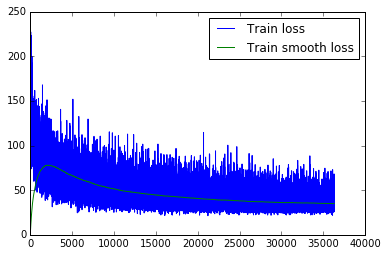

In [95]:
# Hyper-parameters
time_step = 10 # width, minibatch size and test sample size as well
num_layers = 10 # depth
n_iter = 100 # epochs
alpha = 1e-4 # learning_rate
p_dropout = 0.95 # q=1-p, q=keep_prob and p=dropout.
print_after = n_iter//100 # print training loss, valid, and test
num_hidden_units = 64 # num_hidden_units in hidden layer
num_input_units = len(char_to_idx) # vocab_size = len(char_to_idx)
num_output_units = len(char_to_idx)

# Build the network and learning it or optimizing it using SGD
nn = RNN(D=num_input_units, H=num_hidden_units, C=num_output_units, L=num_layers, p_dropout=p_dropout)

# Start learning using BP-SGD-ADAM
nn.adam_rnn(X_train=X, y_train=y, alpha=alpha, mb_size=time_step, n_iter=n_iter, print_after=print_after)

# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(nn.losses['train'], label='Train loss')
plt.plot(nn.losses['smooth train'], label='Train smooth loss')
plt.legend()
plt.show()